 # Spring HGNN

 ## Training HGNN

 ### Import

In [4]:
################################################
################## IMPORT ######################
################################################

from posixpath import split
import sys
import os
from datetime import datetime
from functools import partial, wraps

import fire
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import jit, random, value_and_grad, vmap
from jax.experimental import ode
from shadow.plot import *
from shadow.plot import panel

from psystems.nsprings import (chain, edge_order, get_connections,
                               get_fully_connected_senders_and_receivers,
                               get_fully_edge_order)


MAINPATH = ".."  # nopep8
sys.path.append(MAINPATH)  # nopep8

import jraph
import src
from jax.config import config
from src import lnn
from src.graph_spring import *
from src.md import *
from src.models import MSE, initialize_mlp
from src.nve import nve
from src.utils import *
from src.hamiltonian import *


config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)


def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]


def pprint(*args, namespace=globals()):
    for arg in args:
        print(f"{namestr(arg, namespace)[0]}: {arg}")




In [5]:
N = 5
epochs = 10000
seed = 42
rname = True
saveat = 10
error_fn="L2error",
dt = 1.0e-3
stride = 100
ifdrag = 0
trainm = 1
grid = False
mpass = 1
lr = 0.001
withdata = None
datapoints = None
batch_size = 100
config=None

# def main(N = 5, epochs = 10000, seed = 42, rname = True, saveat = 10, error_fn="L2error",
#         dt = 1.0e-3, stride = 100, ifdrag = 0, trainm = 1, grid = False, mpass = 1, lr = 0.001, withdata = None, datapoints = None, batch_size = 100, config=None):


In [6]:
print("Configs: ")
pprint(N, epochs, seed, rname,
        dt, stride, lr, ifdrag, batch_size,
        namespace=locals())

randfilename = datetime.now().strftime("%m-%d-%Y_%H-%M-%S") + f"_{datapoints}"

PSYS = f"a-{N}-Spring"
TAG = f"3HGNN"
out_dir = f"../results"

def _filename(name, tag=TAG):
    rstring = randfilename if (rname and (tag != "data-ham")) else (
        "0" if (tag == "data-ham") or (withdata == None) else f"0_{withdata}")
    filename_prefix = f"{out_dir}/{PSYS}-{tag}/{rstring}/"
    file = f"{filename_prefix}/{name}"
    os.makedirs(os.path.dirname(file), exist_ok=True)
    filename = f"{filename_prefix}/{name}".replace("//", "/")
    print("===", filename, "===")
    return filename

def OUT(f):
    @wraps(f)
    def func(file, *args, tag=TAG, **kwargs):
        return f(_filename(file, tag=tag), *args, **kwargs)
    return func

loadfile = OUT(src.io.loadfile)
savefile = OUT(src.io.savefile)


Configs: 
N: 5
epochs: 10000
seed: 42
rname: True
dt: 0.001
stride: 100
lr: 0.001
ifdrag: 0
stride: 100


In [7]:
################################################
################## CONFIG ######################
################################################

np.random.seed(seed)
key = random.PRNGKey(seed)

try:
    dataset_states = loadfile(f"model_states_{ifdrag}.pkl", tag="data-ham")[0]
except:
    raise Exception("Generate dataset first.")

if datapoints is not None:
    dataset_states = dataset_states[:datapoints]

model_states = dataset_states[0]
z_out, zdot_out = model_states

print(
    f"Total number of data points: {len(dataset_states)}x{z_out.shape[0]}")

N2, dim = z_out.shape[-2:]
N = N2//2

array = jnp.array([jnp.array(i) for i in dataset_states])

Zs = array[:, 0, :, :, :]
Zs_dot = array[:, 1, :, :, :]

Zs = Zs.reshape(-1, N2, dim)
Zs_dot = Zs_dot.reshape(-1, N2, dim)

mask = np.random.choice(len(Zs), len(Zs), replace=False)
allZs = Zs[mask]
allZs_dot = Zs_dot[mask]

Ntr = int(0.75*len(Zs))
Nts = len(Zs) - Ntr

Zs = allZs[:Ntr]
Zs_dot = allZs_dot[:Ntr]

Zst = allZs[Ntr:]
Zst_dot = allZs_dot[Ntr:]


=== ../results/a-5-Spring-data-ham/0/model_states_0.pkl ===
Total number of data points: 100x100


In [ ]:
# def phi(x):
#     X = jnp.vstack([x[:1, :]*0, x])
#     return jnp.square(X[:-1, :] - X[1:, :]).sum(axis=1) - 1.0


# constraints = get_constraints(N, dim, phi)


################################################
################### ML Model ###################
################################################

if grid:
    print("It's a grid?")
    a = int(np.sqrt(N))
    senders, receivers = get_connections(a, a)
    eorder = edge_order(len(senders))
else:
    print("It's a random?")
    # senders, receivers = get_fully_connected_senders_and_receivers(N)
    print("Creating Chain")
    _, _, senders, receivers = chain(N)
    eorder = edge_order(len(senders))


Ef = 1  # eij dim
Nf = dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2


def get_layers(in_, out_):
    return [in_] + [hidden]*nhidden + [out_]


def mlp(in_, out_, key, **kwargs):
    return initialize_mlp(get_layers(in_, out_), key, **kwargs)


# # fne_params = mlp(Oh, Nei, key)
fneke_params = initialize_mlp([Oh, Nei], key)
fne_params = initialize_mlp([Oh, Nei], key)

fb_params = mlp(Ef, Eei, key)
fv_params = mlp(Nei+Eei, Nei, key)
fe_params = mlp(Nei, Eei, key)

ff1_params = mlp(Eei, 1, key)
ff2_params = mlp(Nei, 1, key)
ff3_params = mlp(dim+Nei, 1, key)
ke_params = initialize_mlp([1+Nei, 10, 10, 1], key, affine=[True])

Hparams = dict(fb=fb_params,
            fv=fv_params,
            fe=fe_params,
            ff1=ff1_params,
            ff2=ff2_params,
            ff3=ff3_params,
            fne=fne_params,
            fneke=fneke_params,
            ke=ke_params)


def H_energy_fn(params, graph):
    g, V, T = cal_graph(params, graph, eorder=eorder,
                        useT=True)
    return T + V


R, V = jnp.split(Zs[0], 2, axis=0)

species = jnp.zeros(N, dtype=int)
state_graph = jraph.GraphsTuple(nodes={
    "position": R,
    "velocity": V,
    "type": species,
},
    edges={},
    senders=senders,
    receivers=receivers,
    n_node=jnp.array([N]),
    n_edge=jnp.array([senders.shape[0]]),
    globals={})

H_energy_fn(Hparams, state_graph)


def energy_fn(species):
    state_graph = jraph.GraphsTuple(nodes={
        "position": R,
        "velocity": V,
        "type": species
    },
        edges={},
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([R.shape[0]]),
        n_edge=jnp.array([senders.shape[0]]),
        globals={})

    def apply(R, V, params):
        state_graph.nodes.update(position=R)
        state_graph.nodes.update(velocity=V)
        return H_energy_fn(params, state_graph)
    return apply


apply_fn = energy_fn(species)
v_apply_fn = vmap(apply_fn, in_axes=(None, 0))


def Hmodel(x, v, params):
    return apply_fn(x, v, params["H"])


params = {"H": Hparams}


def nndrag(v, params):
    return - jnp.abs(models.forward_pass(params, v.reshape(-1), activation_fn=models.SquarePlus)) * v


if ifdrag == 0:
    print("Drag: 0.0")

    def drag(x, v, params):
        return 0.0
elif ifdrag == 1:
    print("Drag: -0.1*v")

    def drag(x, v, params):
        return vmap(nndrag, in_axes=(0, None))(v.reshape(-1), params["drag"]).reshape(-1, 1)

params["drag"] = initialize_mlp([1, 5, 5, 1], key)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=drag, constraints=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

################################################
################## ML Training #################
################################################

LOSS = getattr(src.models, error_fn)

@jit
def loss_fn(params, Rs, Vs, Zs_dot):
    pred = v_zdot_model(Rs, Vs, params)
    return LOSS(pred, Zs_dot)

def gloss(*args):
    return value_and_grad(loss_fn)(*args)

opt_init, opt_update_, get_params = optimizers.adam(lr)

@ jit
def opt_update(i, grads_, opt_state):
    grads_ = jax.tree_map(jnp.nan_to_num, grads_)
    grads_ = jax.tree_map(partial(jnp.clip, a_min=-1000.0, a_max=1000.0), grads_)
    return opt_update_(i, grads_, opt_state)

@ jit
def update(i, opt_state, params, loss__, *data):
    """ Compute the gradient for a batch and update the parameters """
    value, grads_ = gloss(params, *data)
    opt_state = opt_update(i, grads_, opt_state)
    return opt_state, get_params(opt_state), value

@ jit
def step(i, ps, *args):
    return update(i, *ps, *args)

def batching(*args, size=None):
    L = len(args[0])
    if size != None:
        nbatches1 = int((L - 0.5) // size) + 1
        nbatches2 = max(1, nbatches1 - 1)
        size1 = int(L/nbatches1)
        size2 = int(L/nbatches2)
        if size1*nbatches1 > size2*nbatches2:
            size = size1
            nbatches = nbatches1
        else:
            size = size2
            nbatches = nbatches2
    else:
        nbatches = 1
        size = L
    
    newargs = []
    for arg in args:
        newargs += [jnp.array([arg[i*size:(i+1)*size]
                            for i in range(nbatches)])]
    return newargs


Rs, Vs = jnp.split(Zs, 2, axis=1)
Rst, Vst = jnp.split(Zst, 2, axis=1)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot,
                            size=min(len(Rs), batch_size))

print(f"training ...")

opt_state = opt_init(params)
epoch = 0
optimizer_step = -1
larray = []
ltarray = []
last_loss = 1000

larray += [loss_fn(params, Rs, Vs, Zs_dot)]
ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]

def print_loss():
    print(
        f"Epoch: {epoch}/{epochs} Loss (mean of {error_fn}):  train={larray[-1]}, test={ltarray[-1]}")

for epoch in range(epochs):
    for data in zip(bRs, bVs, bZs_dot):
        optimizer_step += 1
        opt_state, params, l_ = step(
            optimizer_step, (opt_state, params, 0), *data)
    
    if epoch % 1 == 0:
        larray += [loss_fn(params, Rs, Vs, Zs_dot)]
        ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]
        
    if epoch % saveat == 0:
        print_loss()
        metadata = {
            "savedat": epoch,
            "mpass": mpass,
            "grid": grid,
            "ifdrag": ifdrag,
            "trainm": trainm,
        }
        savefile(f"hgnn_trained_model_{ifdrag}_{trainm}.dil",
                params, metadata=metadata)
        savefile(f"loss_array_{ifdrag}_{trainm}.dil",
                (larray, ltarray), metadata=metadata)
        
        if last_loss > larray[-1]:
            last_loss = larray[-1]
            savefile(f"hgnn_trained_model_{ifdrag}_{trainm}_low.dil",
                        params, metadata=metadata)
        
        fig, axs = panel(1, 1)
        plt.semilogy(larray[1:], label="Training")
        plt.semilogy(ltarray[1:], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(_filename(f"training_loss_{ifdrag}_{trainm}.png"))

fig, axs = panel(1, 1)
plt.semilogy(larray[1:], label="Training")
plt.semilogy(ltarray[1:], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(_filename(f"training_loss_{ifdrag}_{trainm}.png"))

metadata = {
    "savedat": epoch,
    "mpass": mpass,
    "grid": grid,
    "ifdrag": ifdrag,
    "trainm": trainm,
}

params = get_params(opt_state)
savefile(f"hgnn_trained_model_{ifdrag}_{trainm}.dil",
        params, metadata={"savedat": epoch})
savefile(f"loss_array_{ifdrag}_{trainm}.dil",
        (larray, ltarray), metadata={"savedat": epoch})



 ### Config

In [3]:
seed = 42
lr = 1e-3


ArrayTree = Union[jnp.ndarray,
                  Iterable['ArrayTree'], Mapping[Any, 'ArrayTree']]


class GraphsTuple(NamedTuple):
    nodes: Optional[ArrayTree]
    edges: Optional[ArrayTree]
    receivers: Optional[jnp.ndarray]  # with integer dtype
    senders: Optional[jnp.ndarray]  # with integer dtype
    globals: Optional[ArrayTree]
    n_node: jnp.ndarray  # with integer dtype
    n_edge: jnp.ndarray   # with integer dtype
    e_order: Optional[jnp.ndarray]
    e_mask: jnp.ndarray
    n_mask: jnp.ndarray


dataloc = "../data/LJ_125"
graphs, _ = src.io.loadfile(f"{dataloc}/graphs/graphs_dicts_lammps_cutoff.pkl")
GRAPHS, _ = src.io.loadfile(f"{dataloc}/graphs/mkgraphs_dicts_lammps_cutoff.pkl")


 ### Set directory

In [4]:
datapoints = len(GRAPHS)

randfilename = datetime.now().strftime(
    "%m-%d-%Y_%H-%M-%S") + f"_{datapoints}"

out_dir = dataloc+"/HGNN_redo/"

loadmodel = util.fileloc(src.models.loadmodel, out_dir+"/models/")
savemodel = util.fileloc(src.models.savemodel, out_dir+"/models/")

loadfile = util.fileloc(src.io.loadfile, out_dir)
savefile = util.fileloc(src.io.savefile, out_dir)

save_ovito = util.fileloc(src.io.save_ovito, out_dir+"/ovito/")



In [5]:
################################################
################## CONFIG ######################
################################################
L = 3.9685026299204984 #graphs[0]["L"]
atoms = graphs[0]["atoms"]
displacement_fn, shift_fn = space.periodic(L)

def shift(R, dR, V):
    return shift_fn(R, dR), V

def displacement(R1, R2):
    return vmap(displacement_fn, in_axes=(0, 0))(R1, R2)

np.random.seed(seed)
key = random.PRNGKey(seed)
mask = np.random.choice(len(GRAPHS), len(GRAPHS), replace=False)

try:
    dataset_states = [g for g, m in zip(GRAPHS, mask) if m]
except:
    raise Exception("Generate dataset first.")

if datapoints is not None:
    dataset_states = dataset_states[:datapoints]

state = dataset_states[0]

N, dim = state.nodes["position"].shape

Aatoms, Batoms = atoms.values()
Natoms = sum(atoms.values())
species = GRAPHS[0].nodes["type"][:-1]
# species = np.load(f'{dataloc}/lamp_data/species.npy')
# species = jnp.where(jnp.arange(N) >= Batoms, 1, 0)
# species.sum()
masses = jnp.where(jnp.arange(N) >= Aatoms, 1.0, 1.0)
print(N, Batoms)


76 15


 ### Architecture

In [6]:
def apply_func(f, key=[], apply=None):
    def func(g, params, *args, **kwargs):
        nodes, *extra = g
        b = {k: v for k, v in nodes.items() if k not in key}
        a = {k: v for k, v in nodes.items() if k in key}
        
        def fn(a):
            b.update(a)
            ng = GraphsTuple(b, *extra)
            return f(ng, params)
        if apply is None:
            return fn(a)
        else:
            return apply(fn, *args, **kwargs)(a)
    return func


In [7]:
from typing import Callable, Sequence

from flax import linen as nn
import jax.numpy as jnp
import jraph

def squareplus(x):
    return jax.lax.mul(0.5,
                       jax.lax.add(x, jax.lax.sqrt(jax.lax.add(jax.lax.square(x), 4.0))))

class MLP(nn.Module):
    """A multi-layer perceptron."""
    
    feature_sizes: Sequence[int]
    dropout_rate: float = 0
    deterministic: bool = True
    activation: Callable[[jnp.ndarray], jnp.ndarray] = squareplus
    
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for size in self.feature_sizes:
            x = nn.Dense(features=size)(x)
            x = self.activation(x)
            x = nn.Dropout(
                rate=self.dropout_rate, deterministic=self.deterministic)(x)
        return x



In [8]:
import jax.tree_util as tree
from typing import Any, Callable, Iterable, Mapping, Optional, Union
from frozendict import frozendict


class LagrangianGraphNetwork(nn.Module):
    """A complete Lagrangian Graph Network model defined with Jraph."""
    num_species: int
    
    node_global_latent_size: int = 8
    node_mp_latent_size: int = 8
    edge_mp_latent_size: int = 8
    layer_hidden_dim: int = 16
    num_mlp_layers: int = 2
    message_passing_steps: int = 1
    output_globals_size: int = 0
    mlp_activation = squareplus
    
    edge_global_latent_size: int = None
    
    dropout_rate: float = 0
    skip_connections: bool = True
    use_edge_model: bool = True
    use_ke_model: bool = True
    layer_norm: bool = True
    deterministic: bool = True
    
    initial_edge_embed_fn: Callable = None
    initial_node_embed_fn: Callable = None
    edge_update_fn: Callable = None
    node_update_fn: Callable = None
    
    KE_fn: Callable = None
    PE_fn: Callable = None
    
    def normalize(self, x):
        if self.layer_norm:
            return nn.LayerNorm()(x)
        else:
            return x
    
    def onehot(self, n):
        def fn(n):
            out = jax.nn.one_hot(n, self.num_species*(self.num_species+1) // 2)
            return out
        out = vmap(fn)(n.reshape(-1,))
        return out
    
    def linear_global_node_embed(self, x, *args, **kwargs):
        return nn.Dense(self.node_global_latent_size, *args, **kwargs)(x)
    
    def linear_mp_node_embed(self, x, *args, **kwargs):
        return nn.Dense(self.node_mp_latent_size, *args, **kwargs)(x)
    
    def linear_mp_edge_embed(self, x, *args, **kwargs):
        return nn.Dense(self.edge_mp_latent_size, *args, **kwargs)(x)
    
    def setup(self):
        pass
    
    @nn.compact
    def __call__(self, graphs: GraphsTuple) -> GraphsTuple:
        
        nodes, edges, receivers, senders, globals_, n_node, n_edge, eorder, emask, nmask = graphs
        
        # Equivalent to jnp.sum(n_node), but jittable
        # calculate number of nodes in graph
        sum_n_node = tree.tree_leaves(nodes)[0].shape[0]
        
        # calculate number of edges in graph
        sum_n_edge = senders.shape[0]
        
        # check if all all node array are of same length = number of nodes
        if not tree.tree_all(
                tree.tree_map(lambda n: n.shape[0] == sum_n_node, nodes)):
            raise ValueError(
                'All node arrays in nest must contain the same number of nodes.')
        
        # Initial sent info
        sent_attributes = tree.tree_map(lambda n: n[senders], nodes)
        
        # Initial received info
        received_attributes = tree.tree_map(lambda n: n[receivers], nodes)
        
        # Here we scatter the global features to the corresponding edges,
        # giving us tensors of shape [num_edges, global_feat].
        # i.e create an array per edge for global attributes
        global_edge_attributes = tree.tree_map(lambda g: jnp.repeat(
            g, n_edge, axis=0, total_repeat_length=sum_n_edge), globals_)
        
        # Here we scatter the global features to the corresponding nodes,
        # giving us tensors of shape [num_nodes, global_feat].
        # i.e create an array per node for global attributes
        global_node_attributes = tree.tree_map(lambda g: jnp.repeat(
            g, n_node, axis=0, total_repeat_length=sum_n_node), globals_)
        
        # We will first linearly project the original features as 'embeddings'.
        # apply inital edge embedding
        if self.initial_edge_embed_fn:
            edges = self.initial_edge_embed_fn(self, edges, sent_attributes, received_attributes,
                                               global_edge_attributes)
        # apply initial node embeddings
        if self.initial_node_embed_fn:
            nodes = self.initial_node_embed_fn(self, nodes, sent_attributes,
                                               received_attributes, global_node_attributes)
        
        # Now, we will apply a Graph Network once for each message-passing round.
        # mlp_feature_sizes = [self.latent_size] * self.num_mlp_layers
        for _ in range(self.message_passing_steps):
            if self.node_update_fn:
                nodes = self.node_update_fn(self,
                                            nodes, edges, senders, receivers,
                                            global_node_attributes, sum_n_node)
            
            if self.edge_update_fn:
                senders_attributes = tree.tree_map(
                    lambda n: n[senders], nodes)
                receivers_attributes = tree.tree_map(
                    lambda n: n[receivers], nodes)
                edges = self.edge_update_fn(self, edges, senders_attributes, receivers_attributes,
                                            global_edge_attributes, eorder, _+1 == self.message_passing_steps)
        
        KE = 0.0
        if self.KE_fn:
            KE = KE + self.KE_fn(self, nodes, nmask=nmask)
        
        PEij, PEi = self.PE_fn(self, edges, nodes, senders, receivers, eorder,
                               emask=emask, nmask=nmask)
        return PEij, PEi, KE, edges['dij']
        
        # return GraphsTuple(
        #     nodes=nodes,
        #     edges=edges,
        #     receivers=receivers,
        #     senders=senders,
        #     globals=globals_,
        #     n_node=n_node,
        #     n_edge=n_edge,
        #     e_order=eorder,
        #     e_mask=emask,
        #     n_mask=nmask
        #     )


def HGNN(*args, displacement_fn=None, **kwargs):
    
    ##################
    ## EDGE UPDATES ##
    ##################
    
    ##############
    # EMBEDDING  #
    ##############
    
    def fn_edge_embed(self, e):
        def fn(ei):
            out = self.linear_mp_edge_embed(ei, name="edge_embed_mp")
            return out
        out = vmap(fn, in_axes=(0))(e)
        return out
    
    def initial_edge_embed_fn(self, edges, senders, receivers, globals_):
        del edges, globals_
        dr = displacement_fn(senders["position"], receivers["position"])
        dij = jnp.sqrt(1e-10 + jnp.square(dr).sum(axis=1, keepdims=True))
        eij = dij
        emb = fn_edge_embed(self, eij)
        return frozendict({"edge_embed": emb, "dij": dij})
    
    ##############
    #   UPDATE   #
    ##############
    
    def fn_edge(self, e, s, r):
        def fn(hi, hj):
            c2ij = hi * hj
            mlp_feature_sizes = [self.layer_hidden_dim] * \
                self.num_mlp_layers + [self.edge_mp_latent_size]
            out = MLP(mlp_feature_sizes,
                      dropout_rate=self.dropout_rate,
                      deterministic=self.deterministic)(c2ij)
            return out
        out = vmap(fn, in_axes=(0, 0))(s, r)
        out = self.normalize(out)
        return e + out
    
    def edge_update_fn(self, edges, senders, receivers, globals_, eorder, last_step):
        del globals_
        emb = fn_edge(self, edges["edge_embed"], senders["node_embed"],
                      receivers["node_embed"])
        return frozendict({"edge_embed": emb, "dij": edges["dij"]})
    
    ##################
    ## NODE UPDATES ##
    ##################
    
    ##############
    # EMBEDDING  #
    ##############
    
    def fn_node_embed_ke(self, n):
        def fn(ni):
            out = self.linear_global_node_embed(ni, name="node_embed_ke")
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out
    
    def fn_node_embed_global(self, n):
        def fn(ni):
            out = self.linear_global_node_embed(ni, name="node_embed_global")
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out
    
    def fn_node_embed_mp(self, n):
        def fn(ni):
            out = self.linear_mp_node_embed(ni, name="node_embed_mp")
            return out
        out = vmap(fn, in_axes=(0))(n)
        return out
    
    def initial_node_embed_fn(self, nodes, sent_edges, received_edges, globals_):
        del sent_edges, received_edges, globals_
        type_of_node = nodes["type"]
        ohe = self.onehot(type_of_node)
        
        vel = jnp.sum(jnp.square(nodes["velocity"]), axis=1, keepdims=True)
        # vel = nodes["velocity"]
        
        emb_vel = jnp.hstack(
            [fn_node_embed_ke(self, ohe), vel])
        
        emb_pos = jnp.hstack(
            [fn_node_embed_global(self, ohe), nodes["position"]])
        
        emb_mp = fn_node_embed_mp(self, ohe)
        
        return frozendict({"node_embed": emb_mp,
                           "node_pos_embed": emb_pos,
                           "node_vel_embed": emb_vel,
                           "velocity": nodes['velocity'],
                           "mass": nodes["mass"],
                           })
    
    ##############
    #   UPDATE   #
    ##############
    
    def fn_node(self, n, e, s, r, sum_n_node):
        c1ij = jnp.hstack([n[r], e])
        mlp_feature_sizes = [self.layer_hidden_dim] * \
            self.num_mlp_layers + [self.node_mp_latent_size]
        out = vmap(lambda x: MLP(mlp_feature_sizes,
                                 dropout_rate=self.dropout_rate,
                                 deterministic=self.deterministic)(x))(c1ij)
        out = jax.ops.segment_sum(out, r, sum_n_node)
        out = self.normalize(out)
        return n + out
    
    def node_update_fn(self, nodes, edges, senders, receivers, globals_, sum_n_node):
        del globals_
        emb = fn_node(self, nodes["node_embed"], edges["edge_embed"],
                      senders, receivers, sum_n_node)
        n = dict(nodes)
        n.update({"node_embed": emb})
        return frozendict(n)
    
    ##################
    ##  ENERGY CAL  ##
    ##################
    
    ##############
    ###   KE   ###
    ##############
    
    def fn_node_ke(self, n):
        def fn(ni):
            mlp_feature_sizes = [self.layer_hidden_dim] * \
                self.num_mlp_layers + [1]
            out = MLP(mlp_feature_sizes,
                      dropout_rate=self.dropout_rate,
                      deterministic=self.deterministic, name="MPL_KE")(ni)
            return out
        out = vmap(fn)(n)
        return out
    
    def KE_fn(self, nodes, nmask=None):
        if self.use_ke_model:
            t = fn_node_ke(self, nodes["node_vel_embed"]).flatten()
        else:
            t = 0.5*(nodes["velocity"]**2).sum(axis=1) * nodes["mass"]
        if nmask is not None:
            return jnp.where(nmask, t, 0.0)
        else:
            return t
    
    ##############
    ###   PE   ###
    ##############
    
    def fn_node_l(self, n):
        def fn(ni):
            mlp_feature_sizes = [self.layer_hidden_dim] * \
                self.num_mlp_layers + [1]
            out = MLP(mlp_feature_sizes,
                      dropout_rate=self.dropout_rate,
                      deterministic=self.deterministic, name="MPL_PE_NODE_L")(ni)
            return out
        out = vmap(fn)(n)
        return out
    
    def fn_edge_l(self, e_attr, sen_attr, rec_attr):
        def fn(eij):
            mlp_feature_sizes = [self.layer_hidden_dim] * \
                self.num_mlp_layers + [1]
            out = MLP(mlp_feature_sizes,
                      dropout_rate=self.dropout_rate,
                      deterministic=self.deterministic, name="MPL_PE_EDGE_L")(eij)
            return out
        out = vmap(fn)(e_attr)
        return out
    
    def fn_node_g(self, n):
        def fn(ni):
            mlp_feature_sizes = [self.layer_hidden_dim] * \
                self.num_mlp_layers + [1]
            out = MLP(mlp_feature_sizes,
                      dropout_rate=self.dropout_rate,
                      deterministic=self.deterministic, name="MPL_PE_NODE_G")(ni)
            return out
        out = vmap(fn)(n)
        return out
    
    def PE_fn(self, edges, nodes, senders, receivers, eorder, emask=None, nmask=None):
        VIJ = jnp.array([0.0])
        VI = jnp.array([0.0])
        
        if self.use_edge_model:
            vij = fn_edge_l(self, edges["edge_embed"] + edges["edge_embed"][eorder], nodes["node_embed"]
                        [senders], nodes["node_embed"][receivers]).flatten()
        
        else:
            vij = vmap(lnn.LJ)(edges["dij"]).flatten()    
        # lj = vmap(lnn.LJ)(edges["dij"]).flatten()
        # vij += lj
        
        if emask is not None:
            vij = jnp.where(emask, vij, 0.0)
        
        VIJ += vij
        
        # if self.use_edge_model:
        #     return VIJ, VI
        
        vi = fn_node_l(self, nodes["node_embed"]).flatten()
        vi += fn_node_g(self, nodes["node_pos_embed"]).flatten()
        
        if nmask is None:
            VI += vi
        else:
            VI += jnp.where(nmask, vi, jnp.zeros(vi[0].shape))
        
        
        return VIJ, VI
    
    return LagrangianGraphNetwork(*args,
                                  initial_edge_embed_fn=initial_edge_embed_fn,
                                  initial_node_embed_fn=initial_node_embed_fn,
                                  node_update_fn=node_update_fn,
                                  edge_update_fn=edge_update_fn,
                                  KE_fn=KE_fn,
                                  PE_fn=PE_fn,
                                  **kwargs)



 ![graph_architecture.png](attachment:e7d2e5c8-c36d-48a7-8a59-8e1fbc4ed6e2.png)

 ### Define lagrangian

In [9]:
model = HGNN(len(np.unique(species)),
             displacement_fn=displacement,
             layer_norm=True,
             use_ke_model=True,
             use_edge_model=True,
             node_global_latent_size=10,
             node_mp_latent_size=10,
             edge_mp_latent_size=10,
             layer_hidden_dim=10,
             num_mlp_layers=2,
             message_passing_steps=2,
             )

print(model)
params = model.init(key, GRAPHS[0])
print(list(params['params'].keys()))


def Hmodel(graph, params):
    PEij, PEi, KE, _ = model.apply(params, graph)
    return KE.sum() + PEij.sum() #+ PEi.sum()

# jax.grad(Lmodel, 1)(GRAPHS[0], params).keys


LagrangianGraphNetwork(
    # attributes
    num_species = 2
    node_global_latent_size = 10
    node_mp_latent_size = 10
    edge_mp_latent_size = 10
    layer_hidden_dim = 10
    num_mlp_layers = 2
    message_passing_steps = 2
    output_globals_size = 0
    edge_global_latent_size = None
    dropout_rate = 0
    skip_connections = True
    use_edge_model = True
    use_ke_model = True
    layer_norm = True
    deterministic = True
    initial_edge_embed_fn = initial_edge_embed_fn
    initial_node_embed_fn = initial_node_embed_fn
    edge_update_fn = edge_update_fn
    node_update_fn = node_update_fn
    KE_fn = KE_fn
    PE_fn = PE_fn
)
['edge_embed_mp', 'node_embed_ke', 'node_embed_global', 'node_embed_mp', 'MLP_0', 'LayerNorm_0', 'MLP_1', 'LayerNorm_1', 'MLP_2', 'LayerNorm_2', 'MLP_3', 'LayerNorm_3', 'MPL_KE', 'MPL_PE_EDGE_L', 'MPL_PE_NODE_L', 'MPL_PE_NODE_G']


In [10]:
# import importlib
# importlib.reload(gr)

# state_graph = samegraph(**graphs[0], globals=None)
# state_graph.n_node

# print("\n\nsame graph: ", Lmodel(state_graph, params))

# state_graph = mkgraph(**graphs[0], max_edges=max_edges,  globals=None)
# print("\n\ngraph with padding: ", Lmodel(state_graph, params))

# state_graph2 = samegraph(**graphs[1],  globals=None)
# print("\n\nsame graph 2: ", Lmodel(state_graph2, params))

# state_graph2 = mkgraph(**graphs[1], max_edges=max_edges,  globals=None)
# print("\n\ngraph 2 with padding: ", Lmodel(state_graph2, params))

# state_graph2 = mkgraph(**graphs[1], max_edges=max_edges,  globals=None)
# print("\n\ngraph 1+2 with padding: ",
#       Lmodel(_batch([state_graph, state_graph2], jnp), params))



In [11]:
def ps(*args):
    for arg in args:
        try:
            print(arg.shape)
        except:
            print(arg)

# def hamiltonian(x, p, params):
#     """
#     hamiltonian calls lnn._H
#     x: Vector
#     p: Vector
#     """
#     return None


def get_zdot_lambda(N, Dim, hamiltonian, drag=None, constraints=None, external_force=None):
    dim = N*Dim
    I = jnp.eye(dim)
    J = jnp.zeros((2*dim, 2*dim))
    J = J.at[:dim, dim:].set(I)
    J = J.at[dim:, :dim].set(-I)
    # J = jax.numpy.ndarray.at(J, jax.ops.index[:dim, dim:], I)
    # J = jax.numpy.ndarray.at(J, jax.ops.index[dim:, :dim], -I)
    J2 = jnp.zeros((2*dim, 2*dim))
    J2 = J2.at[:dim, :dim].set(I)
    J2 = J2.at[dim:, dim:].set(I)
    
    def dH_dz(state_graph, params):
        dH_dx = apply_func(hamiltonian, apply=jax.grad, key=[
                           'position'])(state_graph, params)
        # print(dH_dx['position'].flatten())
        dH_dp = apply_func(hamiltonian, apply=jax.grad, key=[
                           'velocity'])(state_graph, params)
        # print(dH_dp['velocity'])
        # dH_dx.values['position'],
        # jnp.hstack([dH_dx, dH_dp])
        return jnp.hstack([dH_dx['position'].flatten(), dH_dp['velocity'].flatten()])
    
    if drag is None:
        def drag(state_graph, params):
            return 0.0
    
    def dD_dz(state_graph, params):
        dD_dx = apply_func(drag, apply=jax.grad, key=[
                           'position'])(state_graph, params)
        dD_dp = apply_func(drag, apply=jax.grad, key=[
                           'velocity'])(state_graph, params)
        return jnp.hstack([dD_dx['position'].flatten(), dD_dp['velocity'].flatten()])
    
    if external_force is None:
        def external_force(state_graph, params):
            return 0.0*state_graph.nodes["velocity"]
    
    if constraints is None:
        def constraints(state_graph, params):
            return jnp.zeros((1, 2*dim))
    
    def fn_zdot(state_graph, params):
        dH = dH_dz(state_graph, params)
        dD = J2 @ dD_dz(state_graph, params)
        dD = - J @ dD
        F = jnp.hstack(
            [jnp.zeros(dim), external_force(state_graph, params).flatten()])
        F = -J @ F
        S = dH + J2 @ dD + F
        A = constraints(state_graph, params).reshape(-1, 2*dim)
        Aᵀ = A.T
        INV = jnp.linalg.pinv(A @ J @ Aᵀ)
        λ = -INV @ A @ J @ S
        zdot = J @ (S + Aᵀ @ λ)
        return zdot.reshape(2*N, Dim)
    
    def lambda_force(state_graph, params):
        dH = dH_dz(state_graph, params)
        dD = J2 @ dD_dz(state_graph, params)
        dD = - J @ dD
        F = jnp.hstack(
            [jnp.zeros(dim), external_force(state_graph, params).flatten()])
        F = -J @ F
        S = dH + J2 @ dD + F
        A = constraints(state_graph, params).reshape(-1, 2*dim)
        Aᵀ = A.T
        INV = jnp.linalg.pinv(A @ J @ Aᵀ)
        λ = -INV @ A @ J @ S
        return (J @ Aᵀ @ λ).reshape(2*N, Dim)
    return fn_zdot, lambda_force


def get_constraints(N, Dim, phi_, mass=None):
    if mass is None:
        mass = 1.0
    
    def phi(x): return phi_(x.reshape(N, Dim))
    
    def phidot(x, p):
        Dphi = jax.jacobian(phi)(x.flatten())
        pm = (p.flatten() / mass)
        return Dphi @ pm
    
    def psi(z):
        x, p = jnp.split(z, 2)
        return jnp.vstack([phi(x), phidot(x, p)])
    
    def Dpsi(z):
        return jax.jacobian(psi)(z)
    
    def fn(x, p, params):
        z = jnp.vstack([x, p])
        return Dpsi(z)
    
    return fn


# def z(x, p): return jnp.vstack([x, p])


 ### Batching

 #### Parallel graphs

In [12]:
def concat_graphs(graphs, size=8):
    nbatches = len(graphs) // size
    return [jax.tree_multimap(lambda *x: jnp.stack(x), *graphs[i*size:(i+1)*size]) for i in range(nbatches)]


BGRAPHS = concat_graphs(GRAPHS, size=4)

zdot_model, lamda_force_model = get_zdot_lambda(
    *BGRAPHS[0].nodes["position"].shape[-2:], Hmodel)

# zdot_model(BGRAPHS[0], params).shape
print((vmap(zdot_model, in_axes=(0, None))(BGRAPHS[0], params)).shape)
# print((vmap(acc_fn, in_axes=(0, None))(BGRAPHS[0], params)).shape)

# Zdots  = vmap(zdot_model, in_axes=(0, None))(BGRAPHS[0], params)

# Zdots.shape


/Users/sureshjyoti/GitHub/Project_LJ-MCGNODE/dgnn/lib/python3.9/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


(4, 152, 3)


 ### LOSS FUNCTION

In [13]:
################################################
################## ML Training #################
################################################
# g = GRAPHS[0]
# print(jnp.vstack([g.nodes["velocity"], g.nodes["acceleration"]]).shape)

@jit
def loss_fn(params, graph):
    nmask = jnp.hstack([graph.n_mask,graph.n_mask])
    A = zdot_model(graph, params)
    # w = graph.nodes["prob"]
    w = 1
    A_pr = jnp.vstack([graph.nodes["velocity"], graph.nodes["acceleration"]])
    squared_error = (jnp.square(A - A_pr) * w).sum(axis=1)
    return jnp.where(nmask, squared_error, 0.0).mean()


vloss_fn = lambda *args: vmap(loss_fn, in_axes=(None, 0))(*args).mean()


@jit
def gloss(*args, **kwargs):
    return value_and_grad(vloss_fn)(*args, **kwargs)


# gloss(params, state_graph)

opt_init, opt_update_, get_params = optimizers.adam(lr)


@ jit
def opt_update(i, grads_, opt_state):
    grads_ = jax.tree_map(jnp.nan_to_num, grads_)
    grads_ = jax.tree_map(
        partial(jnp.clip, a_min=-1000.0, a_max=1000.0), grads_)
    return opt_update_(i, grads_, opt_state)


@jit
def update(i, opt_state, params, loss__, *data):
    """ Compute the gradient for a batch and update the parameters """
    value, grads_ = gloss(params, *data)
    opt_state = opt_update(i, grads_, opt_state)
    return opt_state, get_params(opt_state), value


@ jit
def step(i, ps, *args, **kwargs):
    return update(i, *ps, *args, **kwargs)



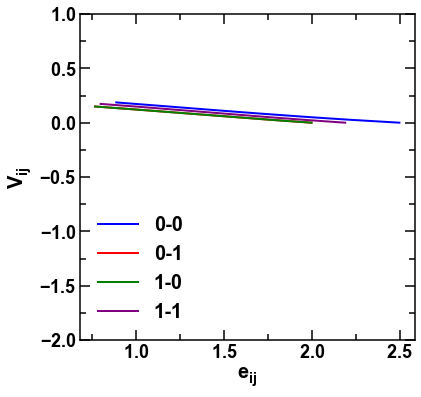

In [14]:
def make_energy_plot(ax):
    g = GRAPHS[0]
    vij, vi, KE, drij = model.apply(params, g)
    
    eij = jnp.sqrt(1e-10 + jnp.square(drij).sum(axis=1))
    
    types_ = jnp.unique(g.nodes["type"])
    
    for a in range(len(types_)):
        for b in range(len(types_)):
            
            mask = (g.nodes["type"][g.senders] == a) & (
                g.nodes["type"][g.receivers] == b)
            mask = (eij >= 0.1) & mask
            
            y = vij[mask]
            x = eij[mask]
            
            mask = jnp.argsort(x)
            x = x[mask]
            y = y[mask]
            y -= y[-1]
            ax.plot(x, y, label=f"{a}-{b}")
    # ax.set_xlim([-2,2])
    ax.set_ylim([-2,1])
    ax.set_xlabel("e$_{ij}$")
    ax.set_ylabel("V$_{ij}$")
    ax.legend()


fig, ax = plt.subplots()
make_energy_plot(ax)


 ### TRAINING

In [15]:
opt_state = opt_init(params)
epoch = 0
optimizer_step = -1
larray = [0.0]
ltarray = [0.0]


epochs = 50000
saveat = 20
plotat = 100


def bDATA(n): return [BGRAPHS[i]
                      for i in np.random.choice(len(BGRAPHS), n, replace=False)]



R$^2$ = 1.00


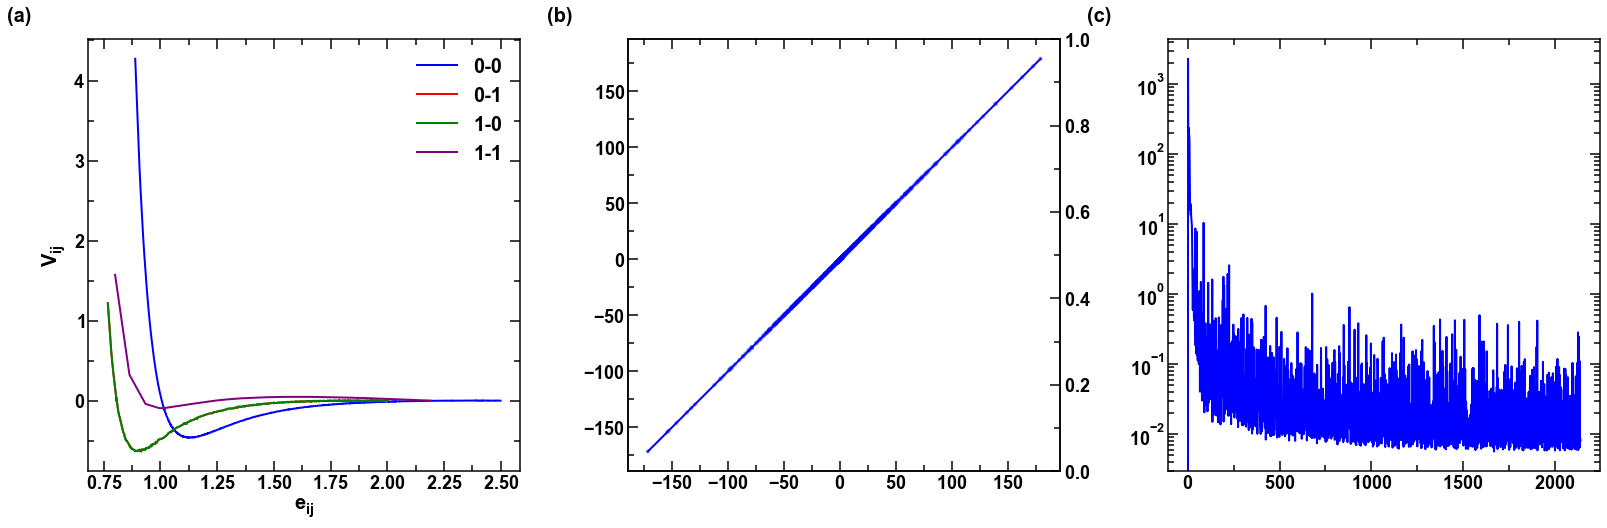

KeyboardInterrupt: 

In [34]:
# vzdot_model = jit(lambda *args: vmap(zdot_model, in_axes=(0, None))(*args))


# def get_acceleration(graph, params):
#     # x = jnp.hstack([graph.nodes["velocity"], graph.nodes["acceleration"]])
#     x = (jnp.hstack([graph.nodes["velocity"], graph.nodes["acceleration"]])[
#          :, :-1, :]).flatten()
#     # y = vzdot_model(graph, params)
#     # print(x.shape,y.shape)
#     y = (vzdot_model(graph, params)[:, :-1, :]).flatten()
#     return x, y


# # %%
# nbatch = 20
# last_loss = 1e6
# for epoch in range(epochs+1):
#     l = 0.0    
#     # for ind, data in enumerate(tqdm(bDATA(nbatch), desc="batched dataset", colour="magenta")):
#     for ind, data in enumerate(bDATA(nbatch)):
#         optimizer_step += 1
#         opt_state, params, l_ = step(
#             optimizer_step, (opt_state, params, 0), data)
#         l += l_
    
#     if epoch % saveat == 0:
#         larray += [l/nbatch]
#         # ltarray += [loss_fn(params, Rst, Vst, Fst)]
#         print(f"Epoch: {epoch+1}/{epochs+1} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")
#         # tqdm.write(
#         #     f"Epoch: {epoch+1}/{epochs+1} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}"
#         # )
#         if last_loss > larray[-1]:
#                     last_loss = larray[-1]
#                     savefile(f"oneh_hgnn_trained_model25feb_low_1.dil", params, metadata={"savedat": epoch}, verbose=True)
            
#     if epoch % plotat == 0:
#         clear_output(wait=True)
#         x = jnp.hstack([get_acceleration(g, params)[0] for g in BGRAPHS[:1]])
#         y = jnp.hstack([get_acceleration(g, params)[1] for g in BGRAPHS[:1]])
#         print(f"R$^2$ = {r2_score(x, y):.2f}")
#         fig, axs = panel(1, 3)
#         make_energy_plot(axs[0])
#         _min = min(x.min(), y.min())
#         _max = max(x.max(), y.max())
#         _range = [_min, _max]
#         axs[1].scatter(x.flatten(), y.flatten(), s=20, alpha=0.3, ec="none")
#         ax2 = plt.twinx(axs[1])
#         # ax2.plot(x.flatten().sort(), KDE_prob(x.flatten().sort()), color="r")
#         axs[1].plot(_range, _range)
#         axs[2].semilogy(larray)
#         plt.show()
        
# savefile(f"oneh_hgnn_trained_model25feb_1.dil", params, metadata={"savedat": epoch}, verbose=True)


In [16]:
# params, _ = loadfile(f"oneh_mclnn_trained_model_0.99_redo.dil", verbose=True)
params, _ = loadfile(f"oneh_hgnn_trained_model25feb_low_1.dil", verbose=True)


Loading ../data/LJ_125/HGNN_redo/oneh_hgnn_trained_model25feb_low_1.dil


In [17]:
vzdot_model = jit(lambda *args: vmap(zdot_model, in_axes=(0, None))(*args))

def get_acceleration(graph, params):    
    x = (jnp.hstack([graph.nodes["velocity"], graph.nodes["acceleration"]])[:, :-1, :]).flatten()
    y = (vzdot_model(graph, params)[:, :-1, :]).flatten()
    return x, y


x = []
y = []
for g in tqdm(bDATA(10)):
    a, b = get_acceleration(g, params)
    x += [a]
    y += [b]

x = jnp.hstack(x)
y = jnp.hstack(y)


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Text(0.15, 0.85, 'R$^2$ = 1.00')

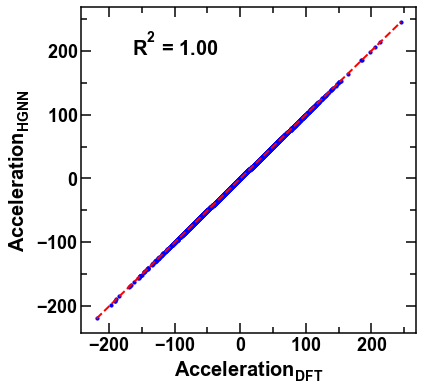

In [18]:
min_ = min(x.min(), y.min())
max_ = max(x.max(), y.max())
range_ = [min_, max_]

plt.scatter(x, y, s=10)
plt.plot(range_, range_, "r--")
plt.xlabel("Acceleration$_{DFT }$")
plt.ylabel("Acceleration$_{HGNN}$")
plt.text(0.15, 0.85, f"R$^2$ = {r2_score(x, y):.2f}",
         transform=plt.gca().transAxes)


# plt.xlim([0, 200])
# plt.ylim([0, 200])



 ### Forward

In [19]:
def VV_step(graph, params, dt=0.001):
    dt = jax_md.util.f64(dt)
    
    def func(i, graph):
        dt_2 = dt*dt
        _, A = zdot_model(graph, params).split(2)
        R = graph.nodes["position"]
        V = graph.nodes["velocity"]
        dR = V * dt + A * dt_2
        R, V = shift(R, dR, V)
        dict1 = graph._asdict()
        dict1["nodes"]["position"] = jax_md.util.f64(R)
        dict1["nodes"]["velocity"] = jax_md.util.f64(V)
        _, A_prime = zdot_model(GraphsTuple(**dict1), params).split(2)
        V = V + jax_md.util.f64(0.5) * (A + A_prime) * dt
        dict1["nodes"]["velocity"] = jax_md.util.f64(V)
        return GraphsTuple(**dict1)
    
    new_graph = jax.lax.fori_loop(0, 100, func, graph)
    
    return new_graph



In [20]:
# importlib.reload(util)
import warnings
from typing import Any, Iterable, Mapping, NamedTuple, Optional, Union

import jax
import jax.numpy as jnp

ArrayTree = Union[jnp.ndarray,
                  Iterable['ArrayTree'], Mapping[Any, 'ArrayTree']]


class GraphsTuple(NamedTuple):
    """Class for holding graph information.
    """
    nodes: Optional[ArrayTree]
    edges: Optional[ArrayTree]
    receivers: Optional[jnp.ndarray]  # with integer dtype
    senders: Optional[jnp.ndarray]  # with integer dtype
    globals: Optional[ArrayTree]
    n_node: jnp.ndarray  # with integer dtype
    n_edge: jnp.ndarray   # with integer dtype
    e_order: Optional[jnp.ndarray]
    e_mask: jnp.ndarray
    n_mask: jnp.ndarray


def pad_graph_with_edges(graph, max_edges):
    """Pad graph to accomodate max edges (as edges can be dynamic in MD simulations).
    
    :param graph: graph tuple
    :type graph: GraphsTuple
    :param max_edges: max number of edges 
    :type max_edges: int
    :return: padded graph tuple
    :rtype: GraphsTuple
    """
    try:
        return pad_with_graphs(graph, graph.n_node.sum()+1, max_edges+1)
    except Exception as excp:
        warnings.warn(excp)
        max_edges += 10
        return pad_graph_with_edges(graph, max_edges)


def mkgraph(*args, mass=None, max_edges=0, L=None, atoms=None, **kwargs):
    """Make graph with padding (edges).
    """
    nodes = kwargs["nodes"]
    # nodes["mass"] = mass[nodes["type"]]
    graph = GraphsTuple(*args,
                        e_mask=jnp.ones(kwargs["senders"].shape, dtype=bool),
                        n_mask=jnp.ones(jnp.sum(kwargs["n_node"]), dtype=bool),
                        **kwargs)
    return pad_graph_with_edges(graph, max_edges)


def samegraph(*args, L=None, atoms=None, **kwargs):
    """make graph from dict.
    """
    graph = GraphsTuple(*args,
                        e_mask=jnp.ones(kwargs["senders"].shape, dtype=bool),
                        n_mask=jnp.ones(jnp.sum(kwargs["n_node"]), dtype=bool),
                        **kwargs)
    return graph


def _batch(graphs, np_):
    """Returns batched graph given a list of graphs and a numpy-like module."""
    # Calculates offsets for sender and receiver arrays, caused by concatenating
    # the nodes arrays.
    offsets = np_.cumsum(
        np_.array([0] + [np_.sum(g.n_node) for g in graphs[:-1]]))
    
    edge_order_offsets = np_.cumsum(
        np_.array([0] + [len(g.senders) for g in graphs[:-1]]))
    
    def _map_concat(nests):
        concat = lambda *args: np_.concatenate(args)
        return jax.tree_multimap(concat, *nests)
    
    return GraphsTuple(
        n_node=np_.concatenate([g.n_node for g in graphs]),
        n_edge=np_.concatenate([g.n_edge for g in graphs]),
        nodes=_map_concat([g.nodes for g in graphs]),
        edges=_map_concat([g.edges for g in graphs]),
        e_mask=_map_concat([g.e_mask for g in graphs]),
        n_mask=_map_concat([g.n_mask for g in graphs]),
        e_order=_map_concat(
            [g.e_order + o for g, o in zip(graphs, edge_order_offsets)]),
        globals=_map_concat([g.globals for g in graphs]),
        senders=np_.concatenate(
            [g.senders + o for g, o in zip(graphs, offsets)]),
        receivers=np_.concatenate(
            [g.receivers + o for g, o in zip(graphs, offsets)]))


def pad_with_graphs(graph: GraphsTuple,
                    n_node: int,
                    n_edge: int,
                    n_graph: int = 2) -> GraphsTuple:
    """Pads a ``GraphsTuple`` to size by adding computation preserving graphs.
    The ``GraphsTuple`` is padded by first adding a dummy graph which contains the
    padding nodes and edges, and then empty graphs without nodes or edges.
    The empty graphs and the dummy graph do not interfer with the graphnet
    calculations on the original graph, and so are computation preserving.
    The padding graph requires at least one node and one graph.
    This function does not support jax.jit, because the shape of the output
    is data-dependent.
    Args:
    graph: ``GraphsTuple`` padded with dummy graph and empty graphs.
    n_node: the number of nodes in the padded ``GraphsTuple``.
    n_edge: the number of edges in the padded ``GraphsTuple``.
    n_graph: the number of graphs in the padded ``GraphsTuple``. Default is 2,
      which is the lowest possible value, because we always have at least one
      graph in the original ``GraphsTuple`` and we need one dummy graph for the
      padding.
    Raises:
    ValueError: if the passed ``n_graph`` is smaller than 2.
    RuntimeError: if the given ``GraphsTuple`` is too large for the given
      padding.
    Returns:
    A padded ``GraphsTuple``.
    """
    np = jnp
    if n_graph < 2:
        raise ValueError(
            f'n_graph is {n_graph}, which is smaller than minimum value of 2.')
    graph = jax.device_get(graph)
    pad_n_node = int(n_node - np.sum(graph.n_node))
    pad_n_edge = int(n_edge - np.sum(graph.n_edge))
    pad_n_graph = int(n_graph - graph.n_node.shape[0])
    if pad_n_node <= 0 or pad_n_edge < 0 or pad_n_graph <= 0:
        raise RuntimeError(
            'Given graph is too large for the given padding. difference: '
            f'n_node {pad_n_node}, n_edge {pad_n_edge}, n_graph {pad_n_graph}')
    
    pad_n_empty_graph = pad_n_graph - 1
    
    tree_nodes_pad = (
        lambda leaf: np.zeros((pad_n_node,) + leaf.shape[1:], dtype=leaf.dtype))
    tree_edges_pad = (
        lambda leaf: np.zeros((pad_n_edge,) + leaf.shape[1:], dtype=leaf.dtype))
    tree_globs_pad = (
        lambda leaf: np.zeros((pad_n_graph,) + leaf.shape[1:], dtype=leaf.dtype))
    
    padding_graph = GraphsTuple(
        n_node=np.concatenate(
            [np.array([pad_n_node], dtype=np.int64),
             np.zeros(pad_n_empty_graph, dtype=np.int64)]),
        n_edge=np.concatenate(
            [np.array([pad_n_edge], dtype=np.int64),
             np.zeros(pad_n_empty_graph, dtype=np.int64)]),
        nodes=jax.tree_map(tree_nodes_pad, graph.nodes),
        edges=jax.tree_map(tree_edges_pad, graph.edges),
        globals=jax.tree_map(tree_globs_pad, graph.globals),
        senders=np.zeros(pad_n_edge, dtype=np.int64),
        receivers=np.zeros(pad_n_edge, dtype=np.int64),
        e_order=jax.tree_map(tree_edges_pad, graph.e_order),
        e_mask=jax.tree_map(tree_edges_pad, graph.e_mask),
        n_mask=jax.tree_map(tree_nodes_pad, graph.n_mask),
    )
    return _batch([graph, padding_graph], np_=np)



In [97]:
GRAPH_A = GraphsTuple(**(GRAPHS[1]._asdict()))

R = GRAPH_A.nodes["position"][:-1]
V = GRAPH_A.nodes["velocity"][:-1]
species = GRAPH_A.nodes["type"][:-1]

k = 1
L_ = 2*L
R, KW = util.periodic_image(np.array(R), L=L,
                            image=[2, 2, 2], V=V, species=species)

V = KW["V"]
species = KW["species"]


def sortall(*args, index=None):
    if index is None:
        return args
    else:
        ind = np.argsort(index)
    LIST = list(args) + [index]
    return [i[ind] for i in LIST]


R, V, species = sortall(R, V, index=species)

box = {"x": {"x": L_}}

atoms = {
    "A": sum(species == 0),
    "B": sum(species == 1)
}

displacement_fn, shift_fn = space.periodic(L_)


def shift(R, dR, V):
    return shift_fn(R, dR), V


def displacement(R1, R2):
    return vmap(displacement_fn, in_axes=(0, 0))(R1, R2)

def matrix_index_fn(matrix,type_a,type_b):
    return matrix[type_a,type_b]

matrix_broadcast_fn=jax.jit(jax.vmap(jax.vmap(matrix_index_fn,(None,0,None)),(None,None,0)))
cutoffs:jnp.ndarray =jnp.array([[2.5 ,2.0],[2.0 ,2.2]],dtype=jnp.float64)
pair_cutoffs=matrix_broadcast_fn(cutoffs,species,species)


g = util.make_graph(R, displacement_fn, atoms=atoms,
                    V=V, mass=[1.0, 1.0], cutoff=pair_cutoffs)

max_edges = 450000 #len(g["senders"])
temp_g = mkgraph(globals=None, max_edges=max_edges, **g)

zdot_model, lamda_force_model = get_zdot_lambda(*temp_g.nodes["position"].shape[-2:], Hmodel)

# acc_fn = accelerationFull(*temp_g.nodes["position"].shape[-2:], Lmodel)



/Users/sureshjyoti/GitHub/Project_LJ-MCGNODE/dgnn/lib/python3.9/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [98]:
dt = 0.001/10
next_graph = jit(lambda graph: VV_step(graph, params, dt=dt))


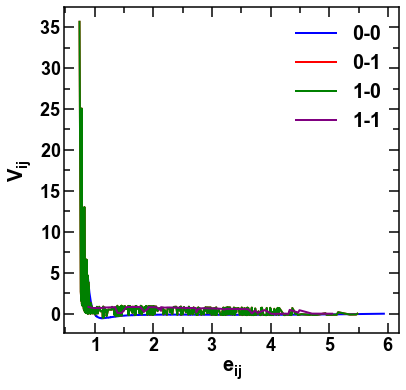

In [103]:
def make_energy_plot(ax):
    g = GRAPHS[3]
    vij, vi, KE, drij = model.apply(params, g)
    
    eij = jnp.sqrt(1e-10 + jnp.square(drij).sum(axis=1))
    
    types_ = jnp.unique(g.nodes["type"])
    
    for a in range(len(types_)):
        for b in range(len(types_)):
            
            mask = (g.nodes["type"][g.senders] == a) & (
                g.nodes["type"][g.receivers] == b)
            mask = (eij >= 0.1) & mask
            
            y = vij[mask]
            x = eij[mask]
            
            mask = jnp.argsort(x)
            x = x[mask]
            y = y[mask]
            y -= y[-1]
            ax.plot(x, y, label=f"{a}-{b}")
    # ax.set_xlim([-2,2])
    # ax.set_ylim([-2,1])
    ax.set_xlabel("e$_{ij}$")
    ax.set_ylabel("V$_{ij}$")
    ax.legend()


fig, ax = plt.subplots()
make_energy_plot(ax)


In [100]:
dump = io.write_dump(f"../data/LJ_125/ovito/LJ_small/LJ_graph_redo.dump")

dict1 = temp_g._asdict()
dict2 = {"nodes": {}}
dict2["nodes"]["position"] = dict1["nodes"]["position"][dict1["n_mask"]]
dict2["nodes"]["velocity"] = dict1["nodes"]["velocity"][dict1["n_mask"]]
dict2["senders"] = dict1["senders"][dict1["e_mask"]]
dict2["receivers"] = dict1["receivers"][dict1["e_mask"]]
dict2["n_node"] = jnp.array([len(dict2["nodes"]["position"])])
dump(dict2, box, atoms=atoms, timestep=0)

for i in tqdm(range(1, 10)):
    print(i)
    # if i==0:
    #     temp_g = GraphsTuple(**(GRAPH_A._asdict()))
    
    # temp_g = VV_step(temp_g, params, dt=dt)
    temp_g = next_graph(temp_g)
        
    g = util.make_graph(temp_g.nodes["position"][:-1], displacement_fn,
                        atoms=atoms, V=temp_g.nodes["velocity"][:-1], mass=[1.0, 1.0], cutoff=pair_cutoffs)
    temp_g = mkgraph(globals=None, max_edges=max_edges, **g)
    
    dict1 = temp_g._asdict()
    dict2 = {"nodes": {}}
    dict2["nodes"]["position"] = dict1["nodes"]["position"][dict1["n_mask"]]
    dict2["nodes"]["velocity"] = dict1["nodes"]["velocity"][dict1["n_mask"]]
    dict2["senders"] = dict1["senders"][dict1["e_mask"]]
    dict2["receivers"] = dict1["receivers"][dict1["e_mask"]]
    dict2["n_node"] = jnp.array([len(dict2["nodes"]["position"])])
    
    dump(dict2, box, atoms=atoms, timestep=i)


Writting to ../data/LJ_125/ovito/LJ_small/28-02-2023_17-54-11_LJ_graph_redo.dump


  0%|          | 0/9 [00:00<?, ?it/s]

1


/Users/sureshjyoti/GitHub/Project_LJ-MCGNODE/dgnn/lib/python3.9/site-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
 11%|█         | 1/9 [00:45<06:06, 45.82s/it]

2


 22%|██▏       | 2/9 [01:21<04:38, 39.79s/it]

3


 33%|███▎      | 3/9 [02:01<03:59, 39.93s/it]

4


 33%|███▎      | 3/9 [02:41<05:23, 53.85s/it]


KeyboardInterrupt: 

In [ ]:
# PEs = []
# KEs = []

# for g in forward_graphs:
#     vij, vi, KE, drij = model.apply(params, g)
#     KEs += [KE.sum()]
#     PEs += [vij.sum() + vi.sum()]


# KEs = jnp.array(KEs)
# PEs = jnp.array(PEs)
# PEs -= PEs[0]


# plt.plot(KEs, label="KE")
# plt.plot(PEs, label="PE")
# plt.plot(KEs+PEs, label="TE")
# plt.legend()

